## Import Packages & Modules

In [ ]:
import sys
sys.path.append('/Users/amberwalker/u-net_semantic_segmentation/')  # Replace with your actual path
from scripts.segmentation_utilities import *

In [ ]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import numpy as np
import re
import tifffile as tiff
from matplotlib import pyplot
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, SpatialDropout2D
from tensorflow.keras import callbacks, layers, losses, metrics, models, optimizers, preprocessing, utils, regularizers, initializers
from tensorflow.keras.metrics import Precision, Recall, AUC, MeanIoU, F1Score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import itertools

## Load data

In [ ]:
# Defines paths
paths = dict(
    images_train= 'data/training/images',
    labels_train= 'data/training/labels',
    images_valid= 'data/validation/images',
    labels_valid= 'data/validation/labels',
    images_test= 'data/test/images',
    labels_test= 'data/test/labels'
)

#load image and label files
image_train_files = search_files(paths['images_train'], '.*\.tif$')
label_train_files = search_files(paths['labels_train'], '.*\.tif$')
image_valid_files = search_files(paths['images_valid'], '.*\.tif$')
label_valid_files = search_files(paths['labels_valid'], '.*\.tif$')


#sort files in the same order
image_train_files.sort()
label_train_files.sort()
image_valid_files.sort()
label_valid_files.sort()

#load images and labels
train_images = load_data(image_train_files)
train_labels = load_data(label_train_files)
val_images = load_data(image_valid_files)
val_labels = load_data(label_valid_files)

In [5]:
#normalize images to range [0, 1]
train_images = train_images.astype(np.float32) / 255.0
val_images = val_images.astype(np.float32) / 255.0

# Set labels data type to float
train_labels = train_labels.astype(np.float32)
val_labels = val_labels.astype(np.float32)

## EDA

Train Images Shape: (2343, 256, 256, 3)
Train Labels Shape: (2343, 256, 256, 1)
Validation Images Shape: (502, 256, 256, 3)
Validation Labels Shape: (502, 256, 256, 1)


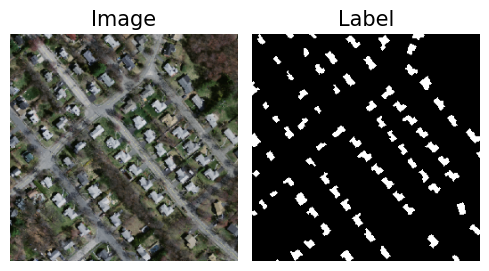

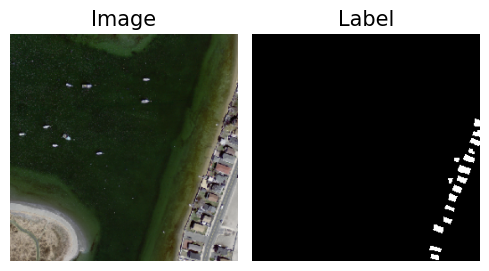

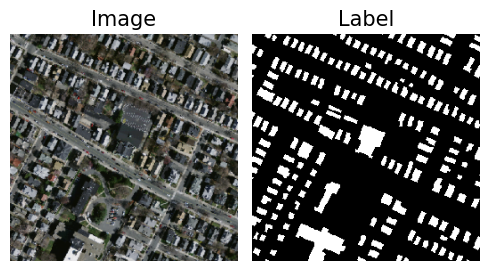

In [6]:
# check dimensions
print('Train Images Shape:', train_images.shape)
print('Train Labels Shape:', train_labels.shape)
print('Validation Images Shape:', val_images.shape)
print('Validation Labels Shape:', val_labels.shape)

# display several matching image and label pairs
n_samples = 3
sample_indices = np.random.choice(train_images.shape[0], n_samples, replace=False)

for idx in sample_indices:
    compare([train_images[idx], train_labels[idx]], titles=['Image', 'Label'])

### Plot the class distribution

In [25]:
image_test_files = search_files(paths['images_test'], '.*\.tif$')
label_test_files = search_files(paths['labels_test'], '.*\.tif$')

image_test_files.sort()
label_test_files.sort()

test_images = load_data(image_test_files)
test_labels = load_data(label_test_files)

test_images = test_images.astype(np.float32) / 255.0
test_labels = test_labels.astype(np.float32)

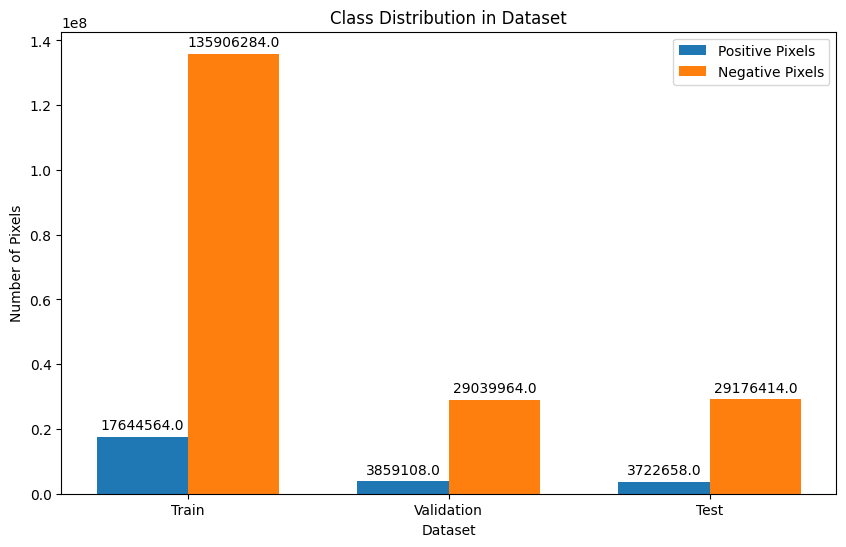

In [8]:
# Calculate class distribution for training, validation, and test labels
train_positive, train_negative = calculate_class_distribution(train_labels)
val_positive, val_negative = calculate_class_distribution(val_labels)
test_positive, test_negative = calculate_class_distribution(test_labels)


# Plot class distribution
train_dist = (train_positive, train_negative)
val_dist = (val_positive, val_negative)
test_dist = (test_positive, test_negative)

plot_class_distribution(train_dist, val_dist, test_dist)

## Model Architecture: Simple U-net:
Using the Keras functional API, define a simplified U-Net model with the number of kernels indicated in the figure above (i.e. 8, 16, 32, 64, 128, ...). There are numerous implementation examples of U-Nets using Keras. Choose the appropriate activation functions for the hidden layers and the output layer, and the corresponding parameter initialisation method.

In [11]:
from tensorflow.keras.layers import UpSampling2D

# Encoder Block with SpatialDropout2D and Custom Kernel
def encoder_block(filters, inputs, dropout_rate=0.1, kernel_initializer='lecun_normal'):
    
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=1, activation='relu',
               kernel_initializer=kernel_initializer)(inputs)
    x = SpatialDropout2D(dropout_rate)(x) 
    s = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=1, activation='relu',
               kernel_initializer=kernel_initializer)(x)
    s = SpatialDropout2D(dropout_rate)(s) 
    p = MaxPooling2D(pool_size=(2, 2), padding='same')(s)
    return s, p 

#baseline layer with SpatialDropout2D and Custom Kernel
def baseline_layer(filters, inputs, dropout_rate=0.1, kernel_initializer='lecun_normal'):
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=1, activation='relu',
               kernel_initializer=kernel_initializer)(inputs)
    x = SpatialDropout2D(dropout_rate)(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=1, activation='relu',
               kernel_initializer=kernel_initializer)(x)
    x = SpatialDropout2D(dropout_rate)(x) 
    return x

#decoder Block with SpatialDropout2D and Custom Kernel
def decoder_block(filters, connections, inputs, dropout_rate=0.1, kernel_initializer='lecun_normal'):
    x = Conv2DTranspose(filters, kernel_size=(2, 2), padding='same', activation='relu', strides=2,
                        kernel_initializer=kernel_initializer)(inputs)
    skip_connections = concatenate([x, connections], axis=-1)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer)(skip_connections)
    x = SpatialDropout2D(dropout_rate)(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer)(x)
    x = SpatialDropout2D(dropout_rate)(x)  
    return x


In [12]:
def unet():
  #Defining the input layer and specifying the shape of the images
  inputs = Input(shape = (256, 256, 3))

  #defining the encoder
  s1, p1 = encoder_block(32, inputs = inputs)
  s2, p2 = encoder_block(64, inputs = p1)
  s3, p3 = encoder_block(128, inputs = p2)
  s4, p4 = encoder_block(256, inputs = p3)

  #Setting up the baseline
  baseline = baseline_layer(512, p4)

  #Defining the entire decoder
  d1 = decoder_block(256, s4, baseline)
  d2 = decoder_block(128, s3, d1)
  d3 = decoder_block(64, s2, d2)
  d4 = decoder_block(32, s1, d3)

  #Setting up the output function for binary classification of pixels
  outputs = Conv2D(1, 1, activation = 'sigmoid')(d4)

  #Finalizing the model
  model = Model(inputs = inputs, outputs = outputs, name = 'Unet')

  return model

## Train and Run Model

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,  # Stop training if no improvement after 3 epochs
    restore_best_weights=True  # Restore weights from the best epoch
)

#initialize the model with batch normalization
unet_simp_sd_model = unet()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

unet_simp_sd_model.compile(
    optimizer=optimizer, 
    loss=combined_loss, 
    metrics=['accuracy', Precision(), Recall(), iou_metric, dice_metric]
)

#train
history = unet_simp_sd_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    batch_size=8,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 89s 187ms/step - accuracy: 0.8752 - dice_metric: 0.1542 - iou_metric: 0.0965 - loss: 1.1653 - precision_2: 0.3091 - recall_2: 0.1425 - val_accuracy: 0.9023 - val_dice_metric: 0.5523 - val_iou_metric: 0.3857 - val_loss: 0.7948 - val_precision_2: 0.5971 - val_recall_2: 0.5150
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.8975 - dice_metric: 0.5395 - iou_metric: 0.3722 - loss: 0.8154 - precision_2: 0.5777 - recall_2: 0.5064 - val_accuracy: 0.9116 - val_dice_metric: 0.5886 - val_iou_metric: 0.4215 - val_loss: 0.7204 - val_precision_2: 0.6511 - val_recall_2: 0.5301
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.9101 - dice_metric: 0.5964 - iou_metric: 0.4272 - loss: 0.7180 - precision_2: 0.6165 - recall_2: 0.5794 - val_accuracy: 0.9214 - val_dice_metric: 0.6326 - val_iou_metric: 0.4666 - val_loss: 0.6449 - val_precision_2: 0.7016 - val_recall_2: 0.5748
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - a

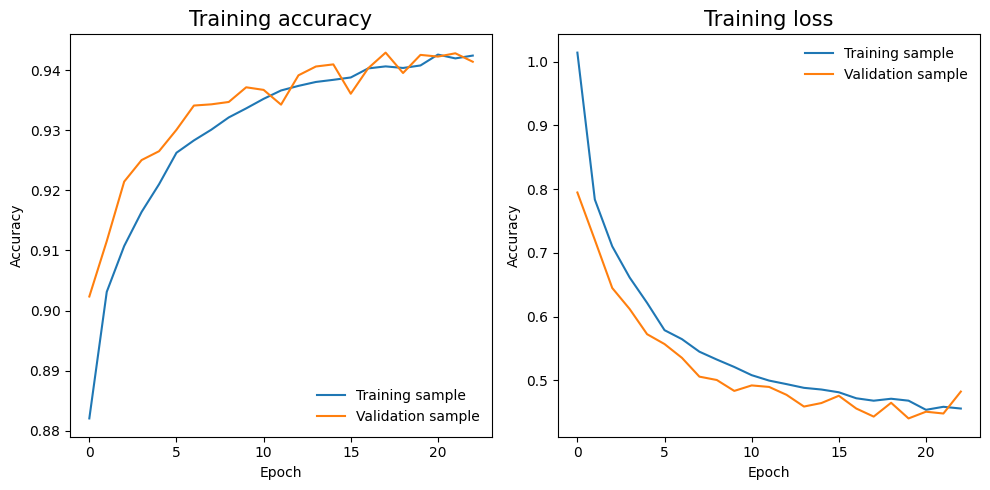

In [15]:
display_history(history.history, metrics=['accuracy', 'loss', 'dice_metric'])


## Evaluate Model

In [18]:
#evaluate the model on the test set
results = unet_simp_sd_model.evaluate(test_images, test_labels)

print(f"Loss: {results[0]}")
print(f"Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Recall: {results[3]}")
print(f"IoU Metric: {results[4]}")
print(f"Dice Metric: {results[5]}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 531ms/step - accuracy: 0.9477 - dice_metric: 0.7738 - iou_metric: 0.6314 - loss: 0.4068 - precision_2: 0.7653 - recall_2: 0.7844
Loss: 0.4161442220211029
Accuracy: 0.9467480182647705
Precision: 0.7523936629295349
Recall: 0.789057195186615
IoU Metric: 0.6223206520080566
Dice Metric: 0.7667822241783142


## Visualize Predictions

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


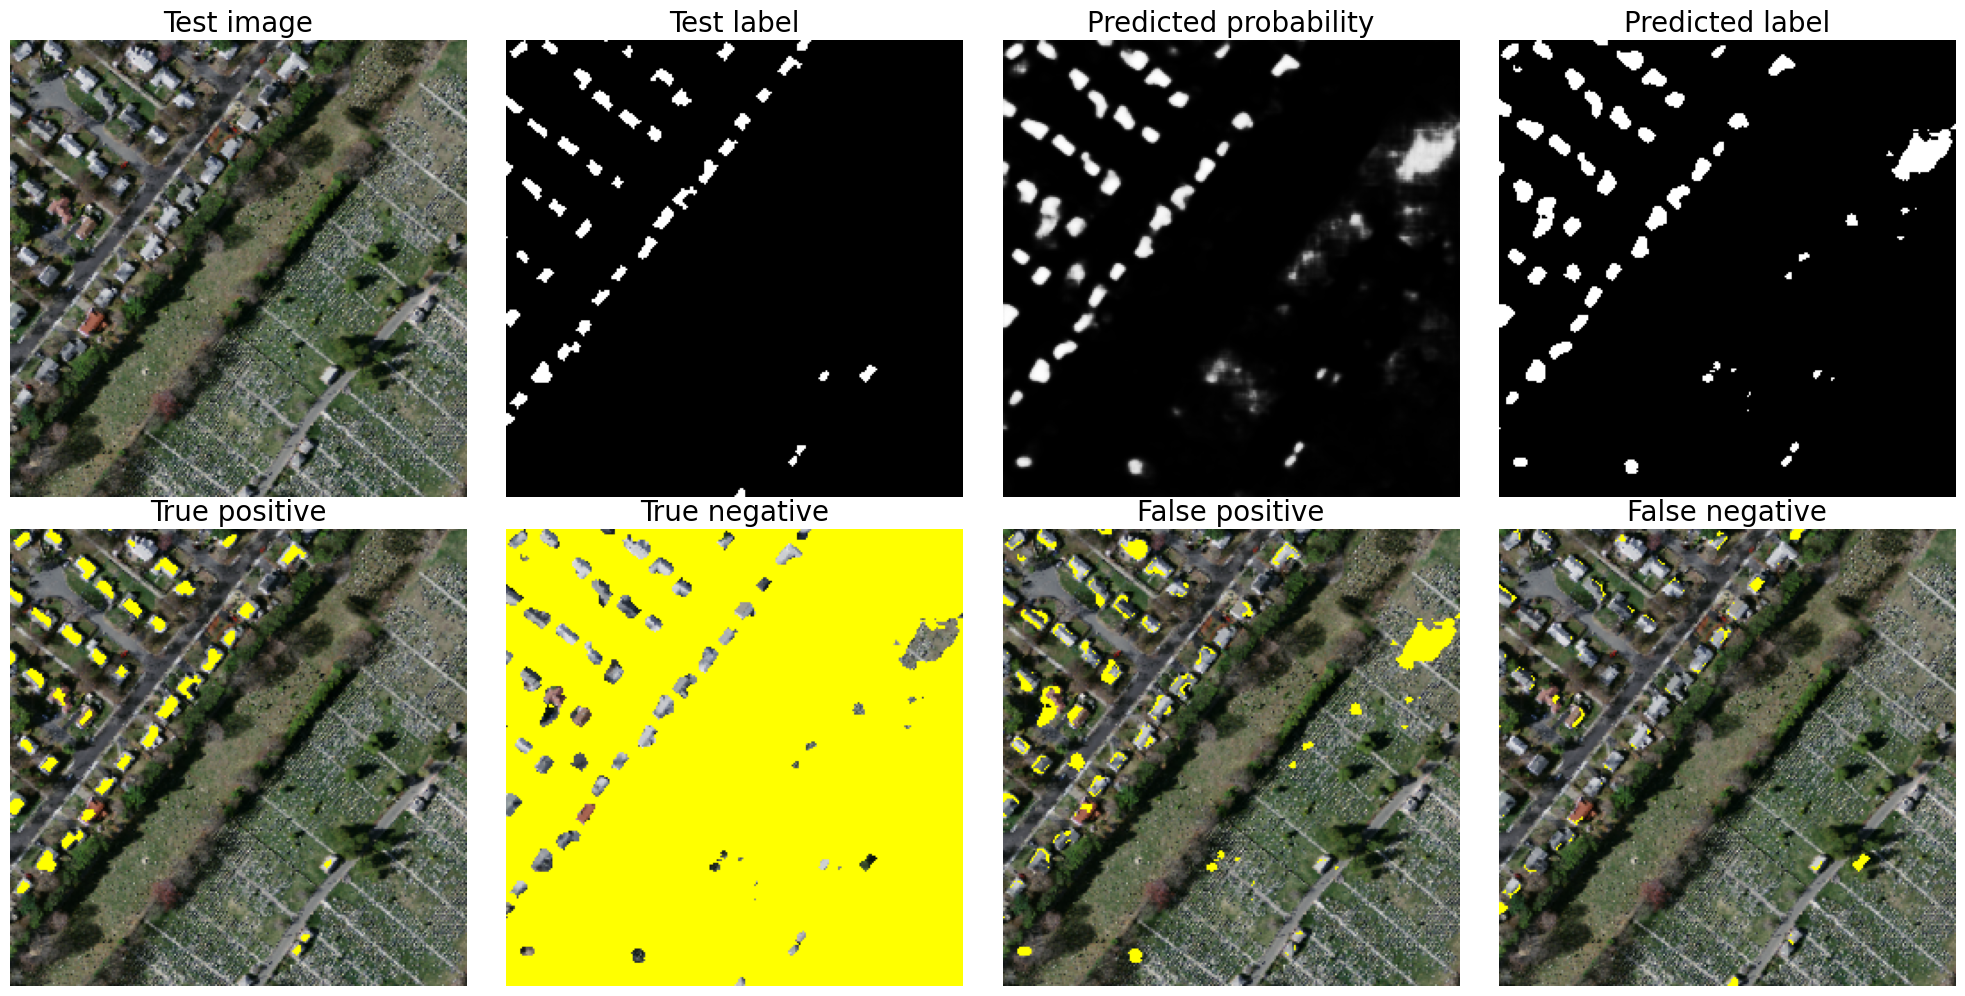

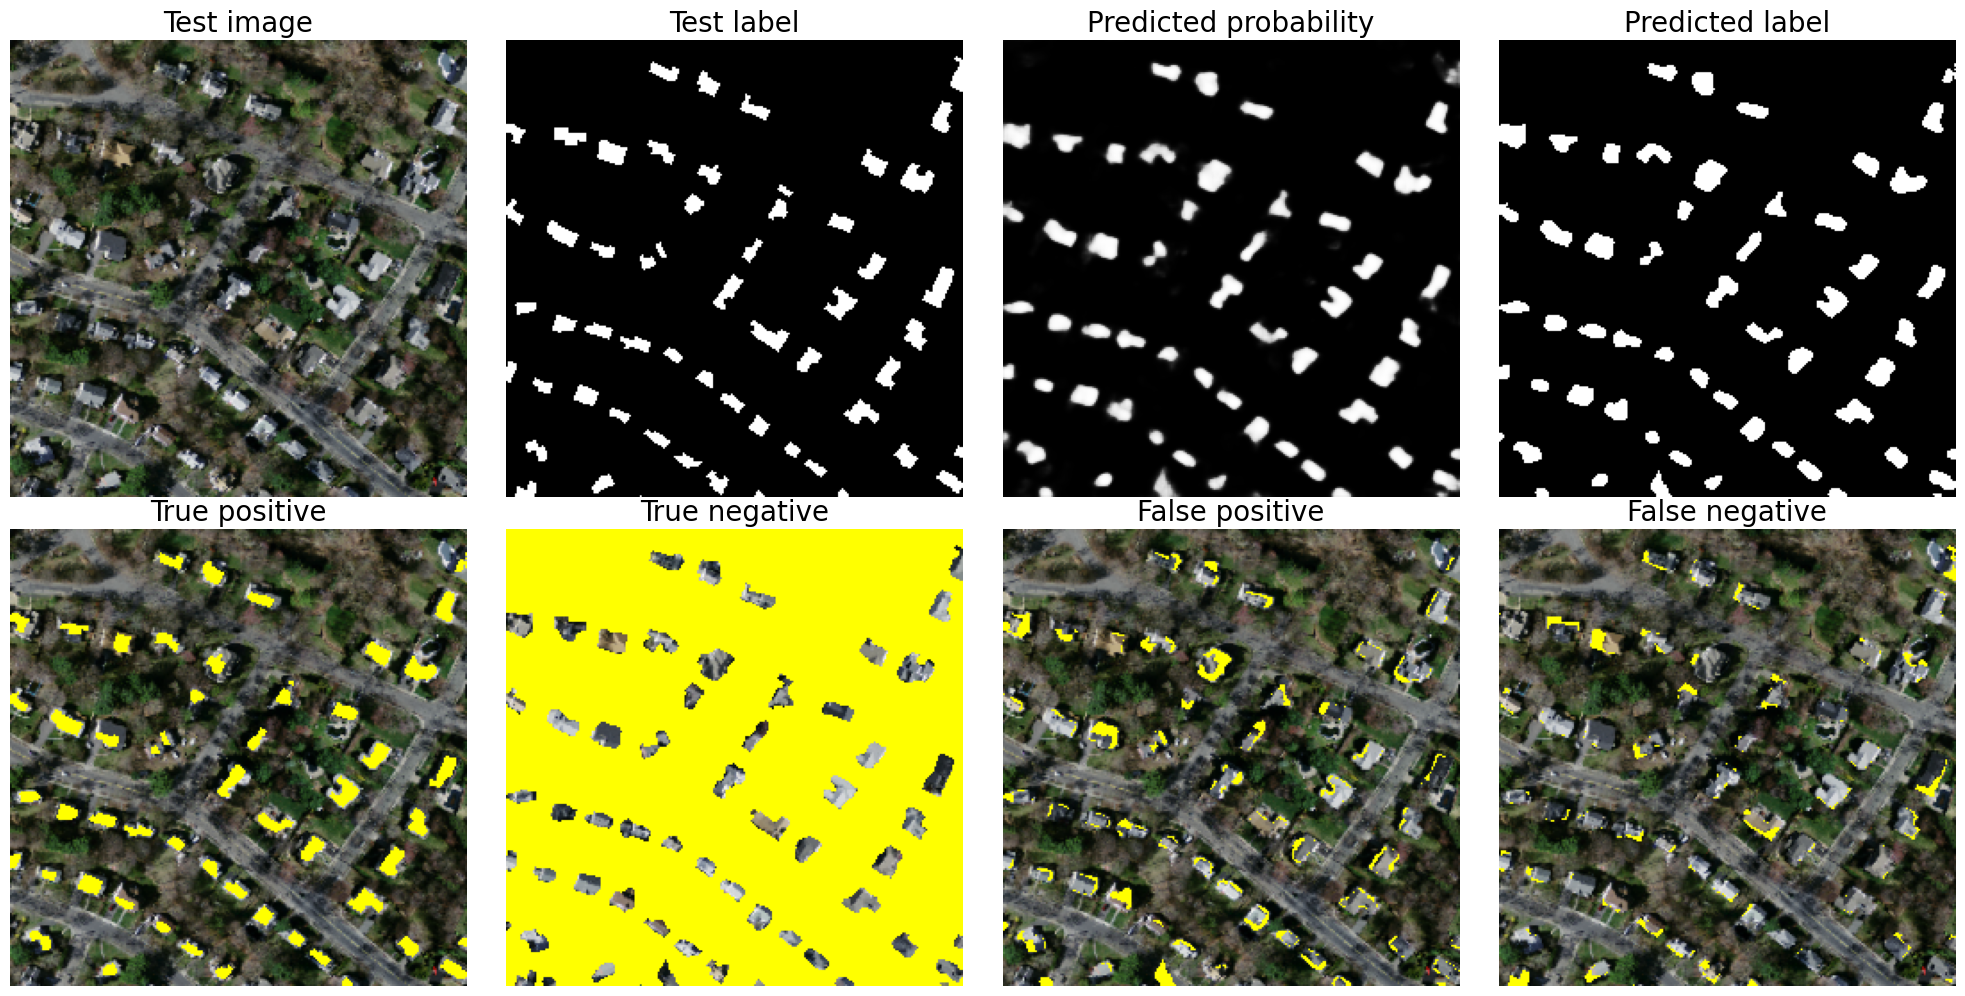

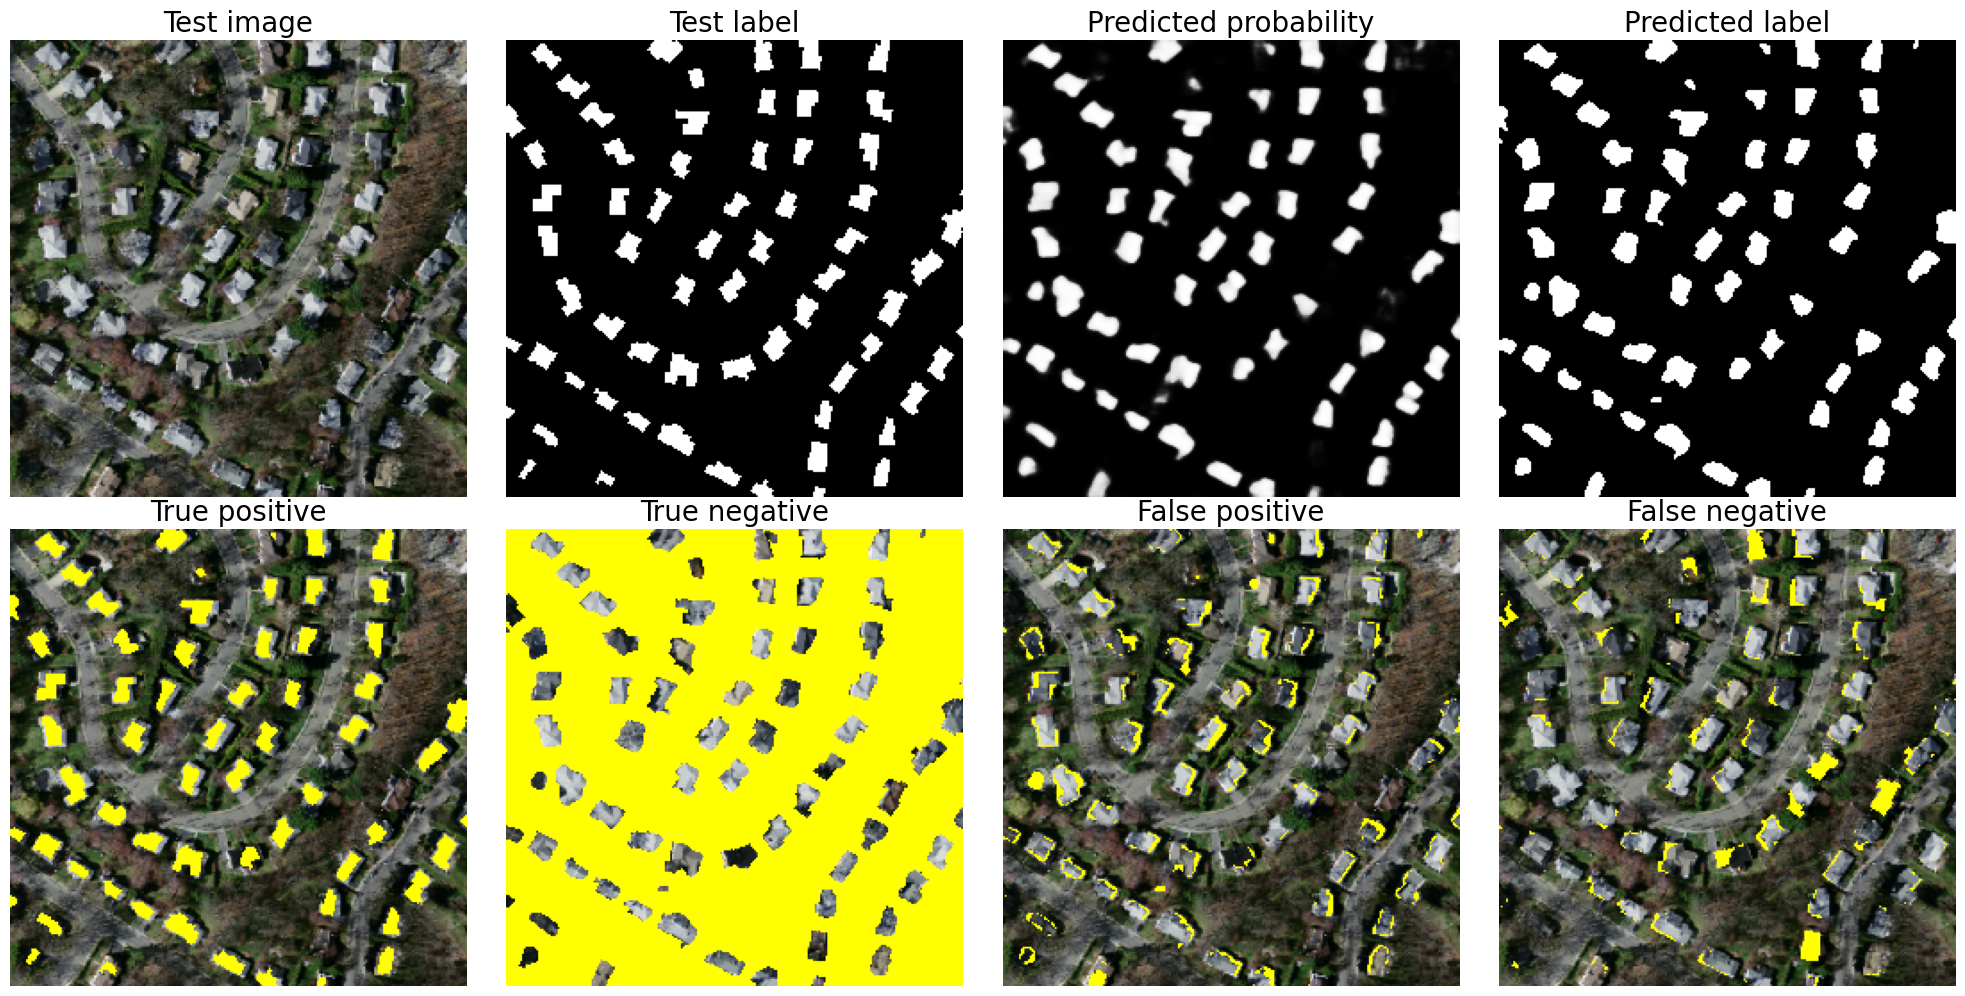

In [28]:
# Generate predictions
test_proba_predict = unet_simp_sd_model.predict(test_images, batch_size=8, verbose="auto")

# Convert probabilities to binary predictions
test_label_predict = (test_proba_predict > 0.5).astype(bool)

# Select sample indices to visualize
samples = [0, 1, 2]  # Indices of test samples

# Ensure test_labels has the correct shape
if test_labels.ndim == 3:
    test_labels = np.expand_dims(test_labels, axis=-1)

# Loop through the selected samples and display statistics
for i in samples:
    display_statistics(
        test_images[i],
        test_labels[i, ..., 0],  # Binary mask (2D)
        test_proba_predict[i, ..., 0],  # Predicted probability (2D)
        test_label_predict[i, ..., 0]  # Binary prediction (2D)
    )